## Imports & Variables

In [1]:
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn
import tensorflow

from collections import Counter
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tqdm import tqdm

plt.figure(figsize=(30,10))

seaborn.set(style="ticks")

<Figure size 2160x720 with 0 Axes>

## Data Collection & Feature Extraction

In [2]:
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pd.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [3]:
def preprocess(dataframe):
    features = []
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, n_mfcc=24, sr=sample_rate)
        features.append(np.mean(mfcc.T, axis=0))
        
    dataframe["features"] = features
    
    return dataframe

dataframe = preprocess(dataframe)

119it [02:46,  1.40s/it]


In [4]:
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

## Feed-Forward Neural Network trained on data from _marsberg_

In [13]:
x = np.array(dataframe_marsberg["features"].tolist())
y = np.array(dataframe_marsberg["label"].tolist())

label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, x_val.shape)

(51, 24) (11, 24) (9, 24)


In [14]:
model = Sequential()
model.add(Dense(400,input_shape=(24,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(800))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 400)               10000     
                                                                 
 activation_4 (Activation)   (None, 400)               0         
                                                                 
 dropout_3 (Dropout)         (None, 400)               0         
                                                                 
 dense_5 (Dense)             (None, 800)               320800    
                                                                 
 activation_5 (Activation)   (None, 800)               0         
                                                                 
 dropout_4 (Dropout)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 400)              

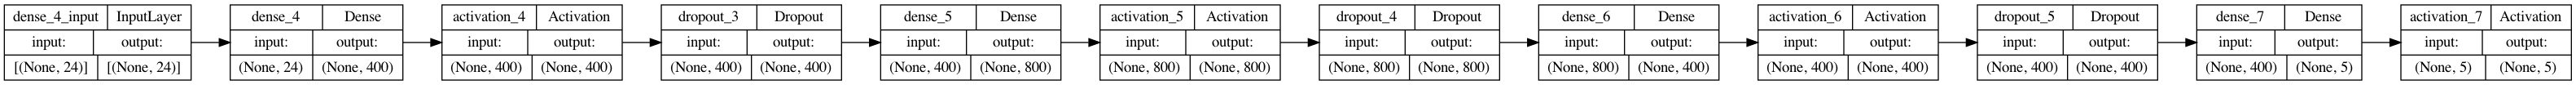

In [15]:
plot_model(model, to_file="files/rnn_visual.png", rankdir="LR", show_shapes=True)

In [16]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['acc'],
    steps_per_execution=100
)

In [17]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=51,
    validation_data=(x_val, y_val),
    shuffle=True
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 66.7696 - acc: 0.1765 - val_loss: 116.1004 - val_acc: 0.1111
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 118.7470 - acc: 0.2157 - val_loss: 113.9632 - val_acc: 0.2222
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 114.3248 - acc: 0.3529 - val_loss: 48.6765 - val_acc: 0.2222
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 91.3825 - acc: 0.1373 - val_loss: 16.3273 - val_acc: 0.1111
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 38.9421 - acc: 0.1569 - val_loss: 18.6411 - val_acc: 0.3333
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 53.2665 - acc: 0.1373 - val_loss: 22.8822 - val_acc: 0.2222
Epoch 7/100
1/1 [==============================] - 0s 57ms/step - loss: 40.0545 - acc: 0.2549 - val_loss: 20.5806 - val_acc: 0.2222
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 32

In [18]:
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

0.3636363744735718


1/1 [==============================] - 0s 146ms/step
[4 1 0 0 1 4 2 4 2 1 3] [4 4 0 4 4 4 4 4 4 4 4]


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

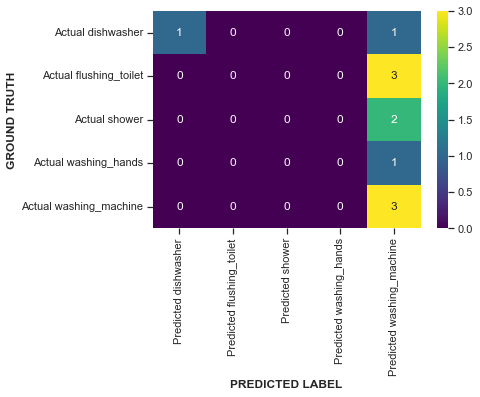

In [19]:
y_true, y_pred = np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1)

def confusion_matrix_table(y_true, y_pred):
    columns = [f'Predicted {label}' for label in label_encoder.classes_]
    index = [f'Actual {label}' for label in label_encoder.classes_]
    print(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    table = pd.DataFrame(cm, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)  
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_true, y_pred)

In [20]:
# Calculate accuracy on data from duesseldorf
x_duesseldorf = np.array(dataframe_duesseldorf["features"].tolist())
y_duesseldorf = np.array(dataframe_duesseldorf["label"].tolist())

y_duesseldorf = to_categorical(label_encoder.fit_transform(y_duesseldorf))

test_accuracy=model.evaluate(x_duesseldorf, y_duesseldorf, verbose=0)
print(test_accuracy[1])

0.03125


2/2 [==============================] - 0s 10ms/step


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

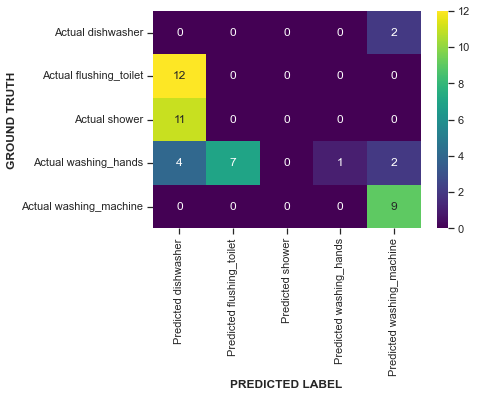

In [21]:
# Generate confusion matrix on data from duesseldorf
y_true, y_pred = np.argmax(y_duesseldorf, axis=1), np.argmax(model.predict(x_duesseldorf), axis=1)

def confusion_matrix_table(y_true, y_pred):
    columns = [f'Predicted {label}' for label in label_encoder.classes_]
    index = [f'Actual {label}' for label in label_encoder.classes_]
    cm = confusion_matrix(y_true, y_pred)
    table = pd.DataFrame(cm, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)  
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_true, y_pred)

## Feed-Forward Neural Network trained on all data

In [22]:
# Prepare and split data for training
x_all = np.array(dataframe["features"].tolist())
y_all = np.array(dataframe["label"].tolist())

label_encoder = LabelEncoder()
y_all = to_categorical(label_encoder.fit_transform(y_all))

x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y_all, test_size=0.15, random_state=1)
x_all_train, x_all_val, y_all_train, y_all_val = train_test_split(x_all_train, y_all_train, test_size=0.15, random_state=1)

print(x_all_train.shape, x_all_test.shape, x_all_val.shape)

(85, 24) (18, 24) (16, 24)


In [23]:
# Configure, compile, and fit model
history_all = model.fit(x_all_train, y_all_train, epochs=72, validation_data=(x_all_val, y_all_val), shuffle=False)

Epoch 1/72
3/3 [==============================] - 1s 243ms/step - loss: 2.3880 - acc: 0.2588 - val_loss: 1.5908 - val_acc: 0.1250
Epoch 2/72
3/3 [==============================] - 0s 15ms/step - loss: 2.2525 - acc: 0.2588 - val_loss: 1.5990 - val_acc: 0.1250
Epoch 3/72
3/3 [==============================] - 0s 15ms/step - loss: 2.3498 - acc: 0.2824 - val_loss: 1.5913 - val_acc: 0.1250
Epoch 4/72
3/3 [==============================] - 0s 15ms/step - loss: 2.6302 - acc: 0.2235 - val_loss: 1.6064 - val_acc: 0.1250
Epoch 5/72
3/3 [==============================] - 0s 15ms/step - loss: 2.0192 - acc: 0.2118 - val_loss: 1.6068 - val_acc: 0.1250
Epoch 6/72
3/3 [==============================] - 0s 16ms/step - loss: 2.3015 - acc: 0.2118 - val_loss: 1.6070 - val_acc: 0.1250
Epoch 7/72
3/3 [==============================] - 0s 16ms/step - loss: 1.9910 - acc: 0.2000 - val_loss: 1.6065 - val_acc: 0.1250
Epoch 8/72
3/3 [==============================] - 0s 15ms/step - loss: 1.7456 - acc: 0.2471 - va

In [24]:
# Calculate accuracy on test dataset
test_accuracy=model.evaluate(x_all_test, y_all_test, verbose=0)
print(test_accuracy[1])

0.1666666716337204


1/1 [==============================] - 0s 18ms/step


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

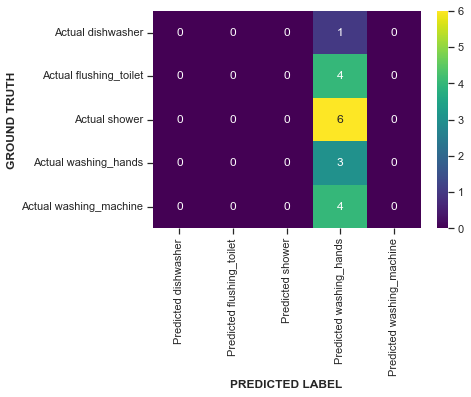

In [25]:
# Generate confusion matrix
y_all_true, y_all_pred = np.argmax(y_all_test, axis=1), np.argmax(model.predict(x_all_test), axis=1)

confusion_matrix_plot(y_all_true, y_all_pred)